 # Opis notatnika
 W tym notatniku stworzymy system analityczno-raportowy, mający wspomagać przyszłe decyzje biznesowe. Dzięki przeprowadzonej wcześniej analizie eksploracyjnej danych, w trakcie spotkania prezentującego wykonaną pracę postanowiono w pierwszym kroku stworzyć następujące wizualizacje danych:
 - Wyświetlenie TOP 10 tras samolotów pod względem najniższego odsetka opóźnień w formie tabeli,
 - Wyświetlenie porównania roku 2019 oraz 2020 w formie wykresu słupkowego:
     - miesiąc do miesiąca,
     - dzień tygodnia do dnia tygodnia,
 - Wyświetlenie danych dzień po dniu w formie szeregu czasowego.

Raport powinien składać się z trzech stron - `TOP report`, `Comparision` i `Day by day reliability`.

Pracując na podstawie wcześniej zdefiniowanych widoków, nie musimy się tutaj martwić o przetwarzanie oraz procesowanie danych. Co więcej, wszystkie niuanse techniczne w postaci liczby wierszy, wykonywanych złączeń, filtracji są przeniesione na bazę danych. Z technicznego punktu widzenia, pomiędzy serwisem a bazą danych dochodzi do przesyłania mniejszej ilości danych.

##### Importujemy potrzebne biblioteki, wczytujemy plik z danymi logowania i nawiązujemy połączenie z bazą danych

In [67]:
import psycopg2
from sqlalchemy import create_engine
from dotenv import load_dotenv
import os
import dash
import threading
from dash import dcc
from dash import html
from dash.dependencies import Input, Output
from dash import dash_table
import webbrowser 
import time
import pandas as pd
import plotly.express as px
import calendar
from threading import Timer
from jupyter_dash import JupyterDash
from IPython.display import Image

In [4]:
# Ładujemy zmienne środowiskowe z pliku .env
load_dotenv('DB_pass.env')

True

In [5]:
# Tworzymy url połączenia
url = f"postgresql://{os.getenv('DB_USER')}:{os.getenv('DB_PASSWORD')}@{os.getenv('DB_HOST')}:{os.getenv('DB_PORT')}/{os.getenv('N_DB_NAME')}"

# Tworzymy engine dla sqlalchemy
engine = create_engine(url)

 # Stworzenie tabeli dla `TOP 10 routes`
 W tym miejscu przygotujemy tabelkę oraz komponent, który zostanie następnie umieszczony w raporcie. Tabela powinna się składać z następujących kolumn:
 - Origin,
 - Destination,
 - Year,
 - Reliability,
 - Rank.

Wartości procentowe zaś powinny być postaci np. 13.87%.

Z tego względu konieczna będzie zmiana nazw kolumn dla wyników raportowania.

##### Zczytujemy dane do ramki danych `top_routes_df` z widoku `reporting.top_reliability_roads`

In [8]:
def read_sql_table(table_name):
    print(f"Loading data from table {table_name} in chunks...")

    # Wczytujemy tabelę z bazy danych w fragmentach po 100 000 wierszy
    part_df = pd.read_sql_table(
        table_name=table_name,
        con=engine,
        schema='reporting',
        index_col=None, # kolumny, które mają być użyte jako indeksy
        coerce_float=True, # jeśli chcemy przekształcić kolumny float na float64
        parse_dates=None, # przekształcenie kolumn na datetime - można zmienić po lepszym zapoznaniu się z danymi
        columns=None, # wybór tylko niektórych kolumn do załadowania
        chunksize=100000 # ilość wierszy na raz - tutaj 100 000 powinno być optymalne
    )

    # Łączymy fragmenty w jeden DF
    df = pd.concat(part_df, ignore_index=True)

    print(f"Data loaded successfully from table {table_name}.")
    return df

In [9]:
top_routes_df = read_sql_table('top_reliability_roads')

Loading data from table top_reliability_roads in chunks...
Data loaded successfully from table top_reliability_roads.


In [10]:
top_routes_df

,origin_airport_id,origin_airport_name,dest_airport_id,dest_airport_name,year,cnt,reliability,nb
0,13930,Chicago O'Hare International,12953,LaGuardia,2019,14219,0.2741,1
1,12953,LaGuardia,13930,Chicago O'Hare International,2019,14203,0.2390,2
2,12892,Los Angeles International,14771,San Francisco International,2019,14096,0.2341,3
3,14771,San Francisco International,12892,Los Angeles International,2019,14088,0.1999,4
4,12892,Los Angeles International,12478,John F. Kennedy International,2019,12797,0.1945,5
5,12892,Los Angeles International,12889,McCarran International,2019,11628,0.1793,6
6,12889,McCarran International,12892,Los Angeles International,2019,11616,0.1753,7
7,12478,John F. Kennedy International,12892,Los Angeles International,2019,12736,0.1385,8
8,13830,Kahului Airport,12173,Hollywood-Burbank Midpoint,2019,10718,0.0642,9
9,12173,Hollywood-Burbank Midpoint,13830,Kahului Airport,2019,10725,0.0545,10


In [11]:
# Aktualizujemy format kolumny 'reliability'
top_routes_df['reliability'] = top_routes_df['reliability'].apply(lambda x: f"{x:.2%}")

In [12]:
# Zmieniamy nazw kolumn plus usuwamy niepotrzebne kolumny
top_routes_df = top_routes_df.rename(columns={
    'origin_airport_name': 'Origin',
    'dest_airport_name': 'Destination',
    'year': 'Year',
    'reliability': 'Reliability',
    'nb': 'Rank'
}).drop(columns=['origin_airport_id', 'dest_airport_id', 'cnt'])

In [13]:
top_routes_df

,Origin,Destination,Year,Reliability,Rank
0,Chicago O'Hare International,LaGuardia,2019,27.41%,1
1,LaGuardia,Chicago O'Hare International,2019,23.90%,2
2,Los Angeles International,San Francisco International,2019,23.41%,3
3,San Francisco International,Los Angeles International,2019,19.99%,4
4,Los Angeles International,John F. Kennedy International,2019,19.45%,5
5,Los Angeles International,McCarran International,2019,17.93%,6
6,McCarran International,Los Angeles International,2019,17.53%,7
7,John F. Kennedy International,Los Angeles International,2019,13.85%,8
8,Kahului Airport,Hollywood-Burbank Midpoint,2019,6.42%,9
9,Hollywood-Burbank Midpoint,Kahului Airport,2019,5.45%,10


 # Porównanie rok do roku (YoY) 2019 vs. 2020
 W tym miejscu stworzymy wykres oraz komponent, który zostanie następnie umieszczony w raporcie. Wykres powinien przedstawiać porównanie lat 2019 oraz 2020 po miesiącach względem zmiennej `reliability`.

 > Na wykresie chcemy również przedstawić dane, które nie mają porównania tj. od kwietnia do grudnia 2019.

 - Przekształcimy dodatkowo tabelkę do formy tabeli przestawnej
 - Stworzymy wykres słupkowy porównujący dane rok do roku
 - Opakujemy stworzony wykres w komponent `Dash`

##### Pobieramy z widoku `reporting.year_to_year_comparision` dane do ramki `yoy_comparision_df`

In [16]:
yoy_comparision_df = read_sql_table('year_to_year_comparision')

Loading data from table year_to_year_comparision in chunks...
Data loaded successfully from table year_to_year_comparision.


In [17]:
yoy_comparision_df.head()

,year,month,flights_amount,reliability
0,2019,1,86826,0.1808
1,2019,2,79514,0.2186
2,2019,3,91789,0.1761
3,2019,4,89505,0.1828
4,2019,5,94256,0.2047


 Tutaj odpowiednio przekształć ramkę, do formy oczekiwanej przez wykres słupkowy. Wyniki zapisz do zmiennej `yoy_comparision_to_plot_df`

In [19]:
# Przekształcamy dane do tabeli przestawnej
yoy_comparision_to_plot_df = yoy_comparision_df.pivot_table(
    index='month',
    columns='year',
    values='reliability'
)

In [20]:
yoy_comparision_to_plot_df

year,2019,2020
month,,
1,0.1808,0.1258
2,0.2186,0.1344
3,0.1761,0.0928
4,0.1828,NaN
5,0.2047,NaN
6,0.2476,NaN
7,0.2167,NaN
8,0.2103,NaN
9,0.1477,NaN


In [21]:
# Zmieniamy typ kolumny 'year' na typ tekstowy
yoy_comparision_df['year'] = yoy_comparision_df['year'].astype(str)

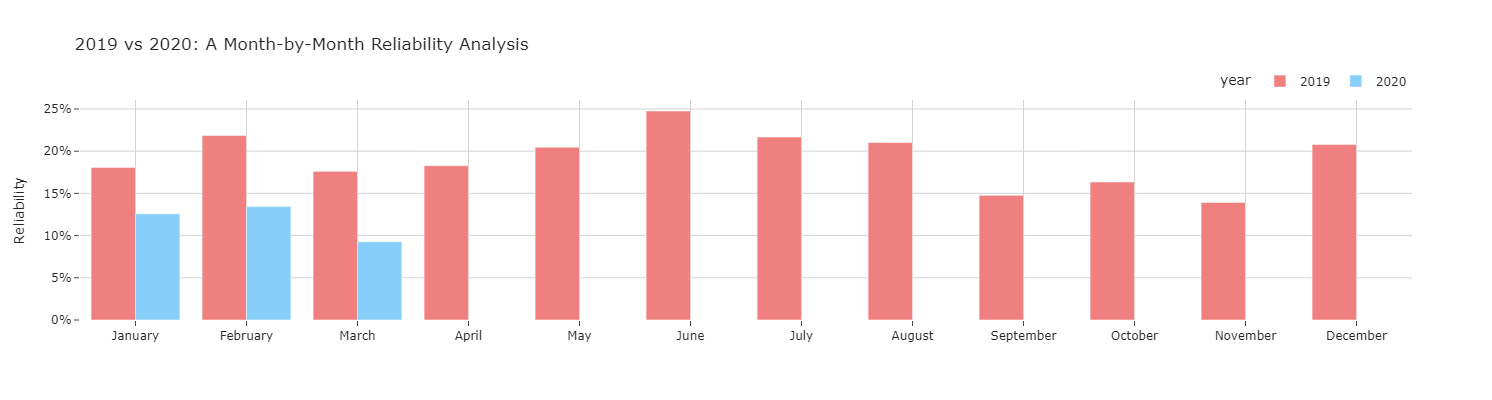

In [73]:
# Tworzymy wykres słupkowy bezpośrednio z ramki yoy_comparision_df
fig = px.bar(yoy_comparision_df, 
             x='month', 
             y='reliability', 
             color='year', 
             barmode='group',
             labels={'reliability': 'Reliability', 'month': ''},
             title='2019 vs 2020: A Month-by-Month Reliability Analysis',
             color_discrete_map={
                 '2019': 'lightcoral', 
                 '2020': 'lightskyblue'
             })

# Tooltipy
fig.update_traces(
    hovertemplate="<b>Month:</b> %{x}<br>" +
                  "<b>Year:</b> %{fullData.name}<br>" +
                  "<b>Reliability:</b> %{y:.2%}<extra></extra>",
    hoverlabel=dict(
        bgcolor='whitesmoke',
        bordercolor="grey",
        font_size=12,
        font_family="Arial"
    )
)

# Zmieniamy formatowanie osi Y na procenty i dostosowujemy wygląd wykresu
fig.update_layout(
    yaxis_tickformat='.0%',
    template='simple_white',
    plot_bgcolor='white',
    height=400,
    xaxis=dict(
        tickmode='array',
        tickvals=list(range(1, 13)),
        ticktext=[calendar.month_name[i] for i in range(1, 13)],
        tickangle=0,
        showgrid=True,
        gridcolor='lightgray',
        showline=False
    ),
    yaxis=dict(
        showgrid=True,
        gridcolor='lightgray',
        showline=False
    ),
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=1.02,
        xanchor='right',
        x=1
    )
)

yoy_comparision_fig = fig

# Zapisanie wykresu jako plik PNG
fig.write_image("yoy_comparision_fig.png", width=1200, height=400)

# Wyświetlanie wykresu
yoy_comparision_fig.show()

##### Wyświetlenie wykresu w png - tylko na potrzeby GitHub

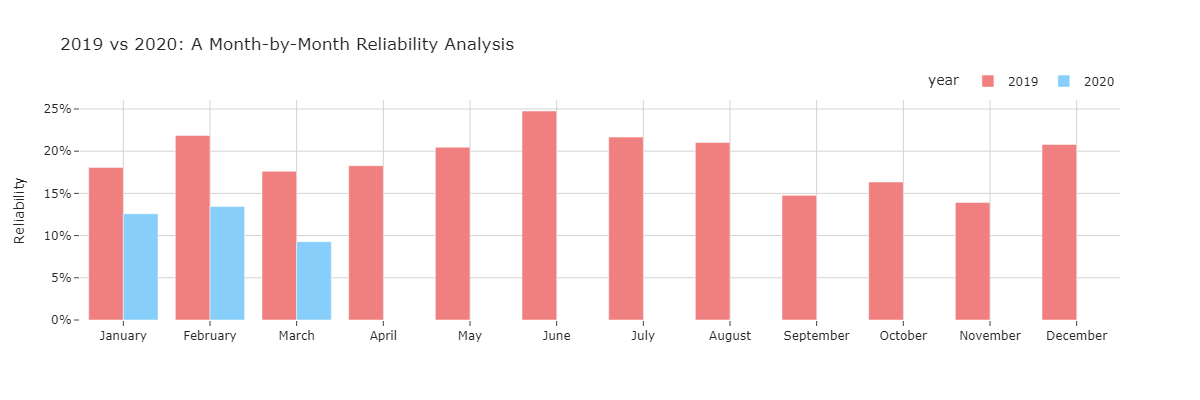

In [75]:
# Wyświetl obraz
Image(filename='yoy_comparision_fig.png')

##### Tworzymy odpowiedni wykres, zapisujemy do na później pod nazwą `yoy_comparision_fig`.

In [26]:
yoy_comparision_fig = fig

 # Porównanie dzień tygodnia do dnia tygodnia (WKoWK) 2019 vs. 2020
Tworzymy analogiczne do poprzedniego kroku, używając danych z widoku `reporting.day_to_day_comparision`

##### Pobieramy z widoku `reporting.day_to_day_comparision` dane do ramki `day_to_day_comparision_df`

In [29]:
day_to_day_comparision_df = read_sql_table('day_to_day_comparision')
day_to_day_comparision_df.head()

Loading data from table day_to_day_comparision in chunks...
Data loaded successfully from table day_to_day_comparision.


,year,day_of_week,flights_amount,reliability
0,2019,1,164325,0.2013
1,2019,2,162265,0.1748
2,2019,3,160092,0.1828
3,2019,4,162989,0.2122
4,2019,5,165283,0.2032


In [30]:
# Zmieniamy typ kolumny 'year' na typ tekstowy
day_to_day_comparision_df['year'] = day_to_day_comparision_df['year'].astype(str)

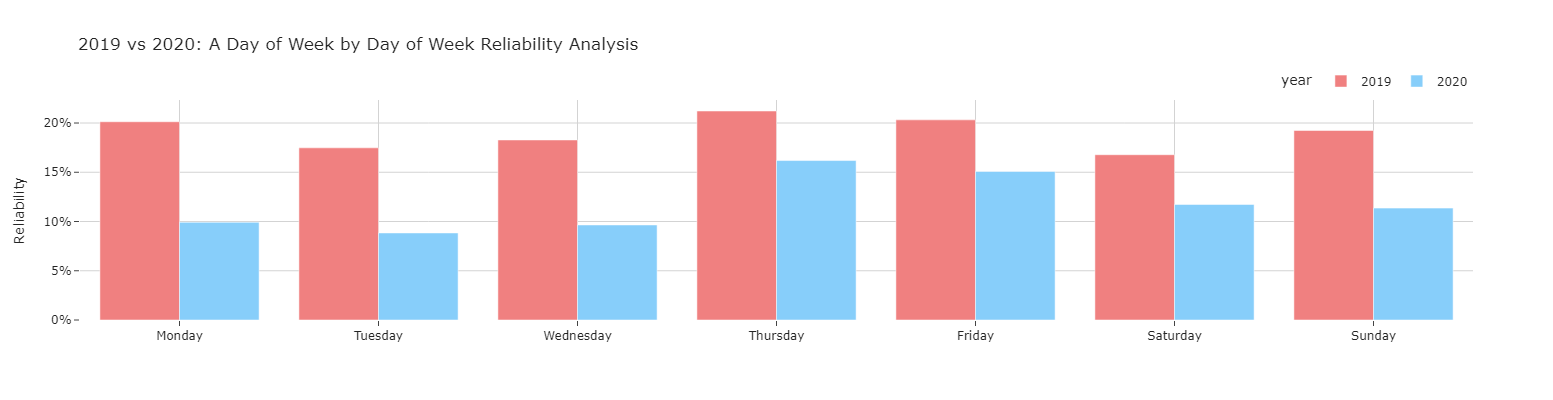

In [31]:
# Tworzymy wykres słupkowy bezpośrednio z ramki yoy_comparision_df
fig = px.bar(day_to_day_comparision_df, 
             x='day_of_week', 
             y='reliability', 
             color='year', 
             barmode='group',
             labels={'reliability': 'Reliability', 'day_of_week': ''},
             title='2019 vs 2020: A Day of Week by Day of Week Reliability Analysis',
             color_discrete_map={
                 '2019': 'lightcoral', 
                 '2020': 'lightskyblue'
             })

# Tooltipy
fig.update_traces(
    hovertemplate="<b>Day of week:</b> %{x}<br>" +
                  "<b>Year:</b> %{fullData.name}<br>" +
                  "<b>Reliability:</b> %{y:.2%}<extra></extra>",
    hoverlabel=dict(
        bgcolor='whitesmoke',
        bordercolor="grey",
        font_size=12,
        font_family="Arial"
    )
)

# Zmieniamy formatowanie osi Y na procenty i dostosowujemy wygląd wykresu
fig.update_layout(
    yaxis_tickformat='.0%',
    template='simple_white',
    plot_bgcolor='white',
    height=400,
    xaxis=dict(
        tickmode='array',
        tickvals=list(range(8)),
        ticktext=[calendar.day_name[i-1] for i in range(8)],
        tickangle=0,
        showgrid=True,
        gridcolor='lightgray',
        showline=False
    ),
    yaxis=dict(
        showgrid=True,
        gridcolor='lightgray',
        showline=False
    ),
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=1.02,
        xanchor='right',
        x=1
    )
)

day_to_day_comparision_fig = fig

# Wyświetlanie wykresu
day_to_day_comparision_fig.show()

 # Stworzenie szeregu czasowego
 W tym miejscu stworzymy wykres w formie szeregu czasowego, który zostanie umieszcony w raporcie. Wykres będzie przedstawiać dane w formie szeregu czasowego (dzień po dniu) dla lat 2019 oraz 2020. Dla możliwości identyfikacji poszczególnych lat, zostaliśmy dodatkowo poproszeni o nadanie innego koloru dla roku 2019 oraz 2020.

In [33]:
day_by_day_reliability_df = read_sql_table('day_by_day_reliability')
day_by_day_reliability_df.head()

Loading data from table day_by_day_reliability in chunks...
Data loaded successfully from table day_by_day_reliability.


,date,reliability
0,2019-01-01,0.1866
1,2019-01-02,0.2151
2,2019-01-03,0.1460
3,2019-01-04,0.1142
4,2019-01-05,0.1882


In [34]:
# Tworzymy kolumnę z rokiem, aby móc zrobić dwa kolory dla różnych lat
day_by_day_reliability_df['date'] = pd.to_datetime(day_by_day_reliability_df['date'])
day_by_day_reliability_df['year'] = day_by_day_reliability_df['date'].dt.year

# Zmieniamy typ kolumny 'year' na typ tekstowy
day_by_day_reliability_df['year'] = day_by_day_reliability_df['year'].astype(str)

Tworzymy wykres liniowy na podstawie pobranych danych. Wynik zapisujemy do zmiennej `day_by_day_reliability_fig`.

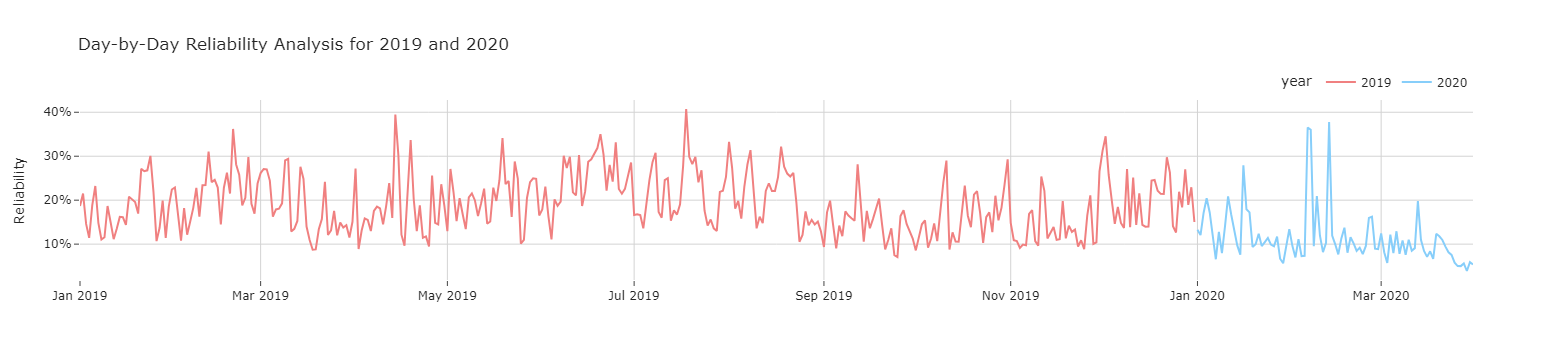

In [36]:
# Tworzenie wykresu liniowego
fig = px.line(day_by_day_reliability_df, 
              x='date', 
              y='reliability', 
              color='year',
              labels={'reliability': 'Reliability', 'date': ''},
              title='Day-by-Day Reliability Analysis for 2019 and 2020',
              color_discrete_map={
                  '2019': 'lightcoral', 
                  '2020': 'lightskyblue'
              })

# Tooltipy
fig.update_traces(
    hovertemplate="<b>Date:</b> %{x}<br>" +
                  "<b>Year:</b> %{fullData.name}<br>" +
                  "<b>Reliability:</b> %{y:.2%}<extra></extra>",
    hoverlabel=dict(
        bgcolor='whitesmoke',
        bordercolor="grey",
        font_size=12,
        font_family="Arial"
    )
)

# Zmieniamy formatowanie osi Y na procenty i dostosowujemy wygląd wykresu
fig.update_layout(
    yaxis_tickformat='.0%',
    template='simple_white',
    plot_bgcolor='white',
    xaxis=dict(
        showgrid=True,
        gridcolor='lightgray',
        showline=False
    ),
    yaxis=dict(
        showgrid=True,
        gridcolor='lightgray',
        showline=False
    ),
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=1.02,
        xanchor='right',
        x=1
    )
)

day_by_day_reliability_fig = fig

# Wyświetlanie wykresu
day_by_day_reliability_fig.show()

 # Stworzenie layoutów poszczególnych stron

 ## Stworzenie layout dla widoku `TOP 10 routes`
 W tym momencie przekonwertujemy zmienną `top_routes_df` w postać `Dash.DataTable`. Dodatkowo, dla czytelności, dodamy nagłówek opisujący co tabela przedstawia.

 Nagłówek stylizujemy używając poniższych wymagań:
 - tag: `H3`,
 - czcionka: `verdana`,
 - kolor: '#4444`,
 - tekst do wyświetlenia: `TOP 10 reliability routes in 2019 and 2020`

Przygotowujemy komponent `Dash` `DataTable`, zapisując wynik do zmiennej `top_routes_table`

In [40]:
top_routes_table = dash_table.DataTable(
    data=top_routes_df.to_dict('records'),
    columns=[{"name": i, "id": i} for i in top_routes_df.columns],
    style_table={'width': '80%', 'margin': '0 auto'}
)

Przygotowujemy nagłówek dla tabeli, zapisując go pod nazwą `top_routes_page_title`

In [42]:
top_routes_page_title = html.H3(
    "TOP 10 reliability routes in 2019 and 2020",
    style={'font-family': 'verdana', 'color': '#444444', 'textAlign': 'center'}
)

Przygotowujemy layout dla widoku `TOP 10 routes`. Konfigurację zapisujemy do zmiennej `top_routes_layout`

In [44]:
top_routes_layout = html.Div([
    top_routes_page_title,  # Nagłówek
    top_routes_table        # Tabela
])

 ## Stworzenie layout dla widoku `Comparision`
 W tym momencie opakujemy zmienne `yoy_comparision_fig` oraz `day_to_day_comparision_fig` do komponentów `Dash`, a następnie stworzymy odpowiedni `layout` dla strony `comparision`. Wyniki zapiszemy do zmiennej `comparision_layout`.

Opakowujemy `yoy_comparision_fig` w odpowiedni komponent `Dash`. Wynik zapisujemy do zmiennej `yoy_comparision_component`.

In [47]:
yoy_comparision_component = dcc.Graph(
    figure=yoy_comparision_fig
)

Opakowujemy `day_to_day_comparision_fig` w odpowiedni komponent `Dash`. Wynik zapisujemy do zmiennej `day_to_day_comparision_component`.

In [49]:
day_to_day_comparision_component = dcc.Graph(
    figure=day_to_day_comparision_fig
)

In [50]:
day_by_day_comparision_component = dcc.Graph(
    figure=day_by_day_reliability_fig
)

Tworzymy odpowiedni `layout` dla widoku `comparision`. Wynik zapisujemy do zmiennej `comparision_layout`.

In [52]:
comparision_layout = html.Div([
    # html.H3("Year-over-Year Comparison", style={'font-family': 'verdana', 'color': '#444444'}),
    yoy_comparision_component,
    # html.H3("Day-to-Day Comparison", style={'font-family': 'verdana', 'color': '#444444'}),
    day_to_day_comparision_component
])

 Tworzymy odpowiedni `layout` dla widoku `day by day`. Wynik zapisujemy do zmiennej `day_by_day_layout`.

In [54]:
#day_by_day_layout = html.Div([
#    html.H3( "Day-by-Day Reliability Analysis", style={'font-family': 'verdana', 'color': '#444444'}),
#    day_by_day_comparision_component
#])

day_by_day_layout = html.Div([
    day_by_day_comparision_component
])

 # Konfigurowanie aplikacji
 Posiadamy już wszystkie niezbędne komponenty do stworzenia oraz uruchomienia aplikacji. Naszym zadaniem w tym miejscu będzie odpowiednie jej skonfigurowanie, aby obsługiwała więcej niż jedną stronę.

 Chcemy, aby możliwe było poruszanie się pomiędzy poniższymi stronami:
 - `TOP report` - strona domyślna,
 - `Comparision` - strona dostępna pod adresem: `comparision_reporting`,
 - `Day by day reporting` - strona dostępna pod adresem: `day_by_day_reporting`

In [56]:
# Inicjalizacja aplikacji
app = dash.Dash(__name__)
app.title = "Reporting Dashboard"
server = app.server

In [57]:
# Definicja nagłówków
header = html.H1(
    "Fly With Me Dashboard",
    style={
        'text-align': 'center',
        'font-family': 'verdana',
        'color': '#444444',
        'backgroundColor': '#e0e0e0',  # Trochę ciemniejsze tło dla nagłówka
        'padding': '20px',
        'margin-bottom': '8px',
        'border-radius': '5px'  # Zaokrąglenie rogów nagłówka
    }
)
# Przycisk nawigacyjny
def navigation_buttons():
    return html.Div(
        children=[
            html.Div("TOP REPORT", id="top-report", className='nav-button'),
            html.Div("COMPARISION", id="comparision", className='nav-button'),
            html.Div("DAY BY DAY REPORTING", id="day-by-day", className='nav-button')
        ],
        style={
            'display': 'flex',
            'justify-content': 'space-around',
            'padding': '10px',
            'backgroundColor': '#f0f0f0',
            'border-radius': '5px',
            'margin-top': '0px'
        }
    )


footer = html.H5(
    "Copyright 2024",
    style={
        'text-align': 'right',
        'font-family': 'verdana',
        'color': '#444444',
        'backgroundColor': '#e0e0e0',  # Trochę ciemniejsze tło dla nagłówka
        'padding': '10px',
        'margin-bottom': '8px',
        'border-radius': '5px'  # Zaokrąglenie rogów nagłówka
    }
)

# Layout aplikacji
app.layout = html.Div([
    header,
    navigation_buttons(),
    dcc.Location(id='url', refresh=False),
    html.Div(id='page-content'),
    footer
])


# Dodanie stylu CSS do przycisków
app.index_string = '''
<!DOCTYPE html>
<html>
    <head>
        {%metas%}
        <title>{%title%}</title>
        {%favicon%}
        {%css%}
        <style>
            .nav-button {
                flex: 1;
                text-align: center;
                padding: 10px;
                cursor: pointer;
                border-radius: 5px;
                background-color: transparent;
                transition: background-color 0.3s ease;
            }
            .nav-button:hover {
                background-color: #e0e0e0;
            }
        </style>
    </head>
    <body>
        {%app_entry%}
        <footer>
            {%config%}
            {%scripts%}
            {%renderer%}
        </footer>
    </body>
</html>
'''

In [58]:
@app.callback(Output('page-content', 'children'),
              [Input('url', 'pathname')])
def display_page(pathname):
    if pathname == '/comparision_reporting':
        return comparision_layout
    elif pathname == '/day_by_day_reporting':
        return day_by_day_layout
    else:
        return top_routes_layout  # Strona główna


In [59]:
@app.callback(Output('url', 'pathname'),
              [Input('top-report', 'n_clicks'),
               Input('comparision', 'n_clicks'),
               Input('day-by-day', 'n_clicks')])
def navigate(n_clicks_top, n_clicks_comparision, n_clicks_day_by_day):
    ctx = dash.callback_context

    if not ctx.triggered:
        return '/'
    button_id = ctx.triggered[0]['prop_id'].split('.')[0]

    if button_id == 'top-report':
        return '/'
    elif button_id == 'comparision':
        return '/comparision_reporting'
    elif button_id == 'day-by-day':
        return '/day_by_day_reporting'
    else:
        return '/'


In [60]:
# Uruchomienie aplikacji
if __name__ == '__main__':
    app.run_server(mode='inline', debug=False)

OSError: Address 'http://127.0.0.1:8050' already in use.
    Try passing a different port to run_server.

 # Podsumowanie
 W tym notatniku stworzyliśmy zgodnie z wymaganiami raport do dyspozycji osób decyzyjnych. Kod źródłowy może w tym momencie zostać przekazany dalej, do działu IT, który następnie wdroży rozwiązanie na serwer dostępny dla każdej zainteresowanej osoby.